In [23]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Make Phantom

In [25]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [26]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1500, 1000),
                               seed = None,
                               )

# skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
skin = tissue.Tissue(name='skin', c=1500, rho=1000, sigma=0, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=40, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
# tumor = tissue.Tissue(name='tumor', c=1550, rho=1050, sigma=0, scale=0.0001, label=5)
tumor = tissue.Tissue(name='tumor', c=1560, rho=1050, sigma=0, scale=0.001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [27]:
test = test_phantom.get_complete()

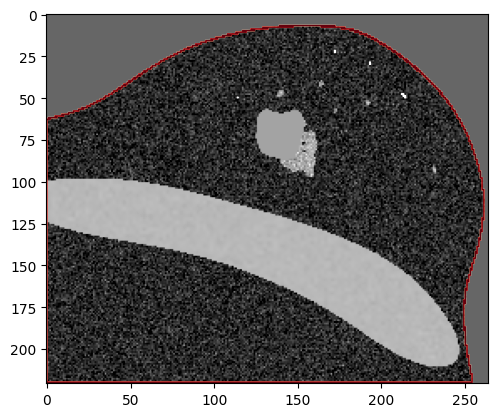

In [28]:
index = 140
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.5*(body_mask[:,:, index]>0)*2, cmap='Reds')

# Set up simulation

In [22]:
# num_transducers = 8192
num_transducers = 1024
transducers = [transducer.Focused(max_frequency=0.75e6,
                                    elements = 1, 
                                    width = 2e-3,
                                    height =  2e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = (0,0),
                                    ray_num = (1,1),
                                    imaging_ndims = 3,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    source_strength = 1e7,
                                    cycles = 2,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [23]:
import math

def fibonacci_sphere(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        x = 1 - (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        radius = math.sqrt(1 - x * x)
        theta = phi * i
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

In [24]:
global_transform = geometry.Transform([np.pi * 0.87,np.pi * -0.05,0],[-0.00,0.005,-0.01], intrinsic=False)
coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi/2)

for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, global_transform * geometry.Transform(angle, global_transform.apply_to_point(coord) * 0.07, intrinsic=False))

In [25]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

In [26]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/00_breast_single_VH_F_skin.obj")).sample_points_uniformly(2000).points)
points = points[:,[0,1,2]] - np.mean(points, axis=0) - np.array([0,0,np.min(points, axis=0)[2]])

# test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0,0))
# test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(0,0))
# test_transducer_set.plot_transducer_fovs(scale = 0.1, view=(90,0))

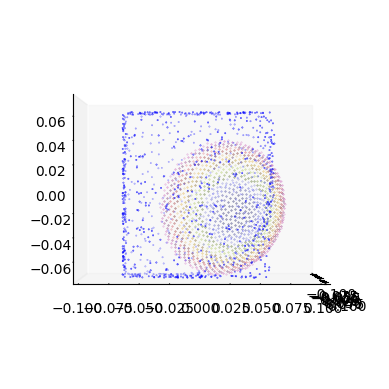

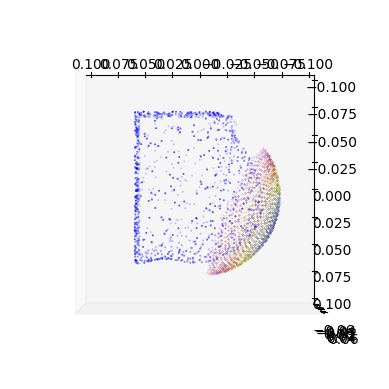

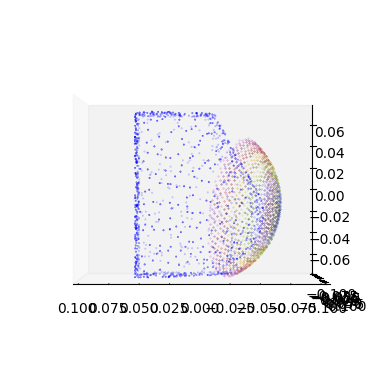

In [27]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/00_breast_single_VH_F_skin.obj")).sample_points_uniformly(1000).points)
points = points[:,[0,1,2]] - np.array(((np.amax(np.array(surface_mesh.vertices)[:,0]) + np.amin(np.array(surface_mesh.vertices)[:,0])) / 2,
                                       (np.amax(np.array(surface_mesh.vertices)[:,1]) + np.amin(np.array(surface_mesh.vertices)[:,1])) / 2,
                                       (np.amax(np.array(surface_mesh.vertices)[:,2]) + np.amin(np.array(surface_mesh.vertices)[:,2])) * -2))

test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(90,90))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,90))

In [28]:
simprops = simulation.SimProperties(
                grid_size   = (90e-3,100e-3,100e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [36]:
# test_experiment = experiment.Experiment(
#                  simulation_path = 'breast_3D_planewave_net',
#                  sim_properties  = simprops,
#                  phantom         = test_phantom,
#                  transducer_set  = test_transducer_set,
#                  sensor          = test_sensor,
#                  nodes           = 1,
#                  results         = None,
#                  indices         = None,
#                  workers         = 3,
#                  additional_keys = ['p_max_all']
#                  )

test_experiment = experiment.Experiment(
                 simulation_path = 'breast_synthetic_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [30]:
# utils.save_mrc(test_experiment.get_sensor_mask(pad=50), 'breast_tomography_sensor_mask.mrc')

In [31]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

In [32]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 180, slice(0, -1, 1)])

In [33]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

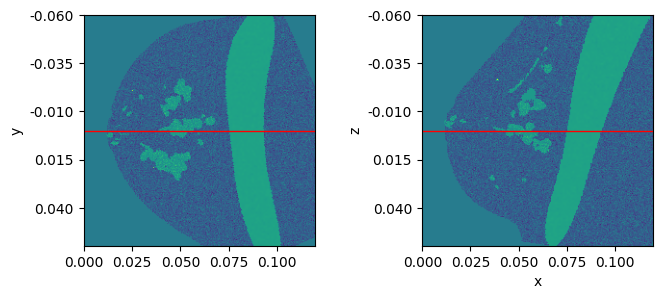

In [34]:
test_experiment.plot_ray_path(0)

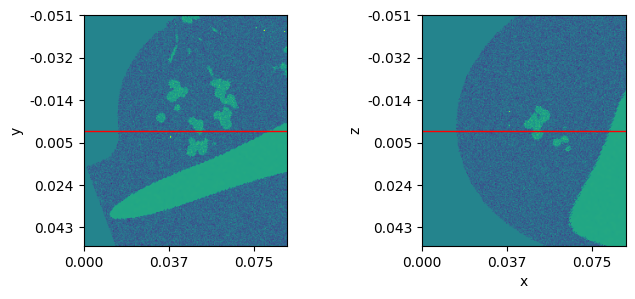

In [20]:
test_experiment.plot_ray_path(4095)

# Run Simulation

In [24]:
test_experiment = experiment.Experiment.load('breast_synthetic_aperture')
test_experiment.run(dry=True, dry_fast=True)

dry run of simulation
Fast dry runs only works when all transducers are identical, use dry_fast=False if your transducers differ from each other


100%|██████████| 1024/1024 [00:00<00:00, 1410035.23it/s]


In [38]:
test_experiment.run(repeat=False)

running with 3 workers

preparation for sim    0 completed in 23.38 seconds
preparation for sim  512 completed in 24.06 seconds
preparation for sim    1 completed in 24.42 seconds
simulation             0 completed in 26.17 seconds
preparation for sim  513 completed in 24.11 seconds
simulation           512 completed in 26.23 seconds
preparation for sim    2 completed in 23.82 seconds
simulation             1 completed in 25.86 seconds
preparation for sim  514 completed in 24.57 seconds
simulation           513 completed in 26.59 seconds
preparation for sim    3 completed in 24.18 seconds
simulation             2 completed in 25.96 seconds


KeyboardInterrupt: 

preparation for sim  515 completed in 24.13 seconds
simulation           514 completed in 26.47 seconds
preparation for sim    4 completed in 24.33 seconds
simulation             3 completed in 26.09 seconds
preparation for sim    5 completed in 23.46 seconds
simulation           515 completed in 26.58 seconds
preparation for sim  516 completed in 24.57 seconds
simulation             4 completed in 26.88 seconds
preparation for sim    6 completed in 24.70 seconds
simulation             5 completed in 27.40 seconds
preparation for sim  517 completed in 24.83 seconds
simulation           516 completed in 26.81 seconds
preparation for sim  518 completed in 24.96 seconds
preparation for sim    7 completed in 24.30 seconds
simulation             6 completed in 27.23 seconds
simulation           517 completed in 26.65 seconds
preparation for sim    8 completed in 24.32 seconds
simulation             7 completed in 26.51 seconds
preparation for sim  519 completed in 24.15 seconds
simulation  

Process run:
Traceback (most recent call last):
  File "/home/trevor/miniconda3/envs/musik/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/trevor/miniconda3/envs/musik/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/trevor/repos/MUSiK/core/experiment.py", line 333, in run_worker
    simulation.run()
  File "/home/trevor/repos/MUSiK/core/simulation.py", line 204, in run
    self.__run_by_index(self.index, dry=self.dry)
  File "/home/trevor/repos/MUSiK/core/simulation.py", line 237, in __run_by_index
    time_array, signals, other_signals = self.__run_simulation(self.prepped_simulation, self.additional_keys)
  File "/home/trevor/repos/MUSiK/core/simulation.py", line 312, in __run_simulation
    sensor_data = kwave.kspaceFirstOrder3D.kspaceFirstOrder3D(
  File "/home/trevor/repos/MUSiK/k-wave-python/kwave/kspaceFirstOrder3D.py", line 473, in kspaceFirstOrder3D
    sensor

prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 

# Reconstruction

In [2]:
# test_experiment = experiment.Experiment.load('breast_synthetic_aperture')
test_experiment = experiment.Experiment.load('recon_testing')
test_experiment.run(dry=True, workers=8, dry_fast=True)
test_experiment.add_results()

dry run of simulation
Fast dry runs only works when all transducers are identical, use dry_fast=False if your transducers differ from each other


100%|██████████| 2/2 [00:00<00:00, 35394.97it/s]


In [3]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [4]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, combine=False, volumetric=True, attenuation_factor = 40, save_intermediates=False)

100%|██████████| 2/2 [00:00<00:00, 11814.94it/s]


running reconstruction on 2 rays
running reconstruction on ray 0
preprocessing finished in 0.003110647201538086
local matrix created in 0.10656094551086426
transmit_dists computed in 0.2020435333251953
el2el_dists computed in 0.05813908576965332
starting loop
loop completed in 6.73272180557251
hilbert transform computed in 2.021632194519043
starting interpolater
interpolation completed in 3.8099145889282227
running reconstruction on ray 1
preprocessing finished in 0.0013720989227294922
local matrix created in 0.16225337982177734
transmit_dists computed in 0.3428325653076172
el2el_dists computed in 0.10081648826599121
starting loop
loop completed in 9.127907752990723
hilbert transform computed in 5.135777473449707
starting interpolater
interpolation completed in 4.353710412979126


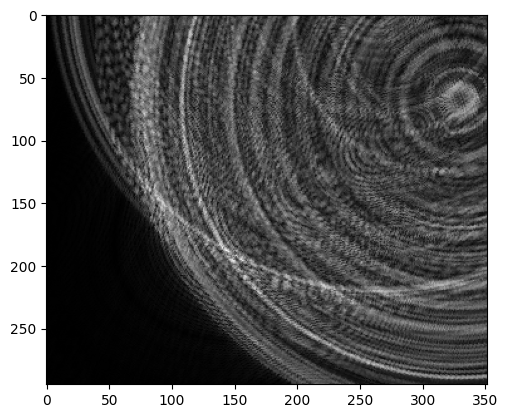

In [10]:
plt.imshow(np.sum(images2 ,axis=0)[:,:,100], cmap='gray')

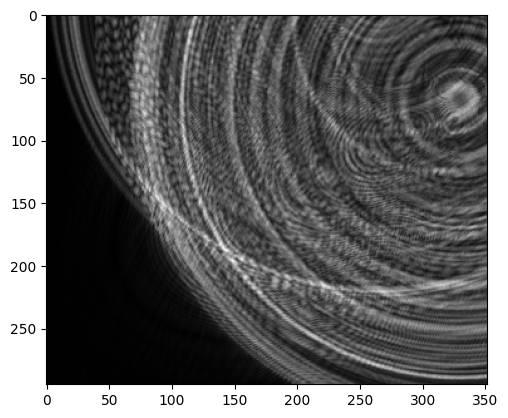

In [5]:
plt.imshow(np.sum(images2 ,axis=0)[:,:,100], cmap='gray')

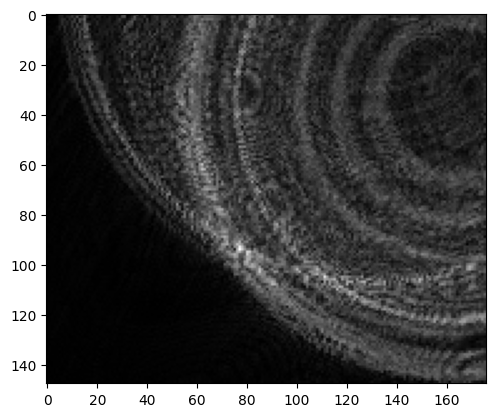

In [5]:
plt.imshow(np.sum(images2 ,axis=0)[:,:,100], cmap='gray')

In [13]:
files = glob.glob('breast_synthetic_aperture/reconstruct/intermediate_image_000*.npz')
images = []
for path in tqdm.tqdm(files):
    images.append(utils.load_array(path))


image1 = utils.load_array(files[0])
for file in tqdm.tqdm(files[1:]):
    image1 = image1 + utils.load_array(file)
    
image1 = image1/len(files)

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 255/255 [00:01<00:00, 216.92it/s]


In [18]:
image = np.sum(np.array(images))

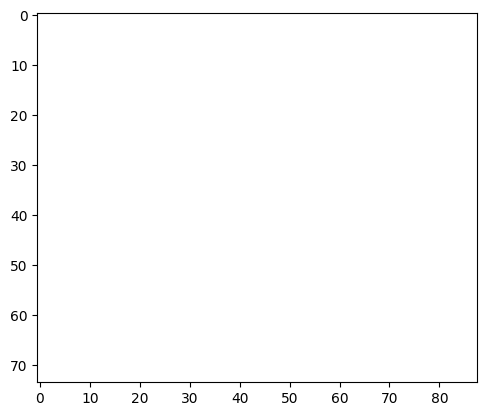

In [19]:
plt.imshow(images[0][:,:,47],)

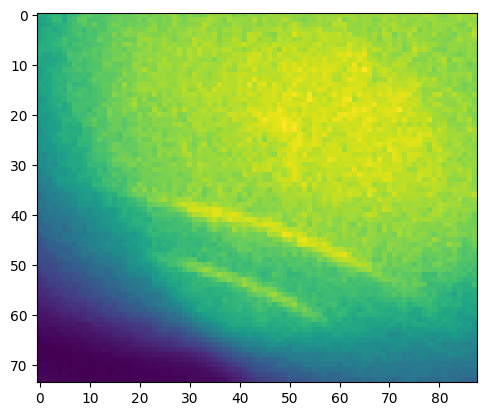

In [ ]:
plt.imshow(image[:,:,47])

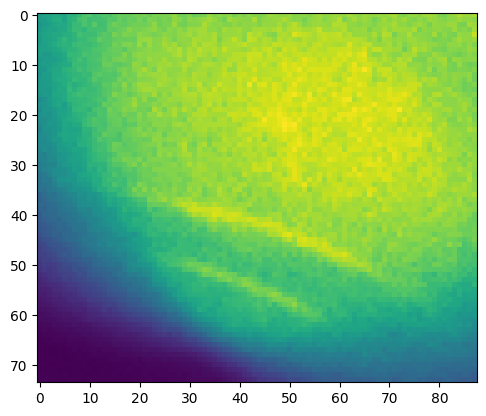

In [ ]:
plt.imshow(image1[:,:,47])

In [ ]:
images3 = test_reconstruction.compound(workers=16, resolution_multiplier=0.5, local=True, combine=False, volumetric=False, attenuation_factor = 32)

In [ ]:
image3 = np.sum(images3, axis=0)/len(images3)

In [ ]:
plt.imshow(images3[23][:,:,0])

In [ ]:
plt.imshow(images3[15][:,:,0])

In [ ]:
plt.imshow(image3[:,:,0])

In [ ]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 140])

In [ ]:
plt.imshow(images2[5][:,:,90], vmin=0, vmax=4000)

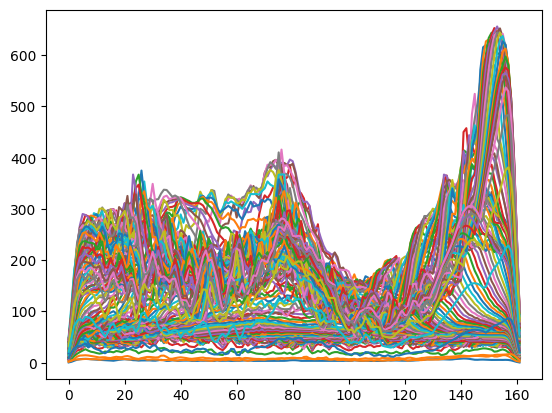

In [40]:
plt.plot(utils.load_array('breast_3D_planewave_net/results/key_signal_00_000000.npy'))

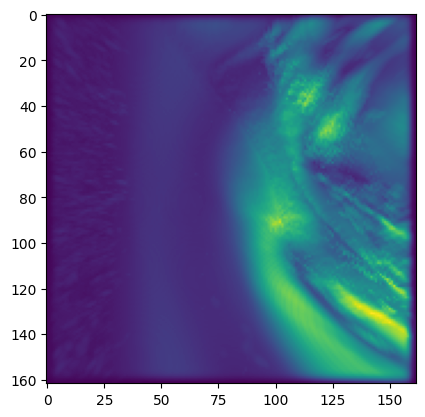

In [58]:
plt.imshow(utils.load_array('breast_3D_planewave_net/results/key_signal_00_000100.npy'))

In [2]:
# files = glob.glob('breast_3D_planewave_net/reconstruct/intermediate_image_00*.npz')
files = glob.glob('breast_synthetic_aperture/reconstruct/intermediate_image_00*.npz')
images1 = []
for path in tqdm.tqdm(files):
    images1.append(utils.load_array(path))
images1 = np.array(images1)

image1 = np.sum(images1, axis=0)/len(images1)

100%|██████████| 276/276 [00:07<00:00, 34.62it/s]


In [3]:
image1.shape

(111, 132, 142)

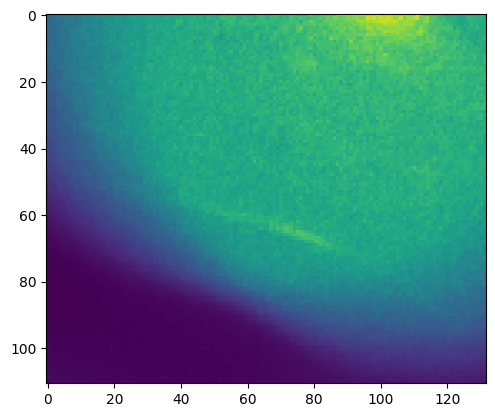

In [5]:
plt.imshow(image1[:,:,80])

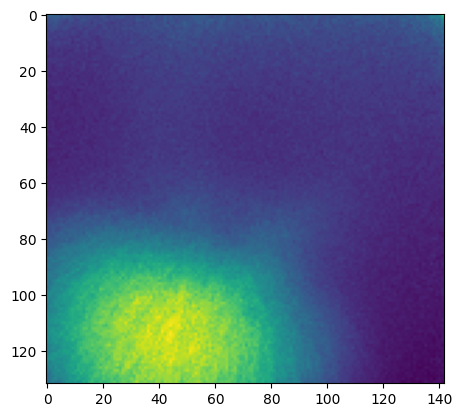

In [10]:
plt.imshow(image1[110,:,:])

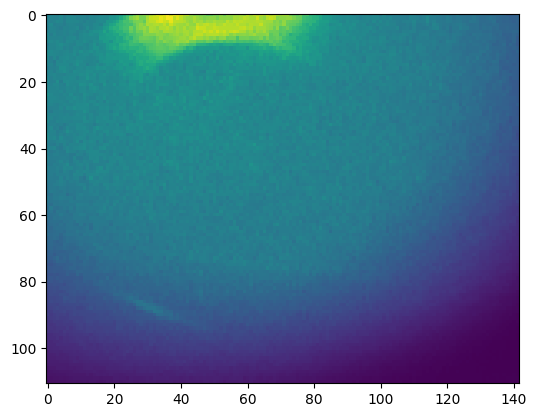

In [22]:
plt.imshow(image1[:,100,:])

In [30]:
# test = test[0]

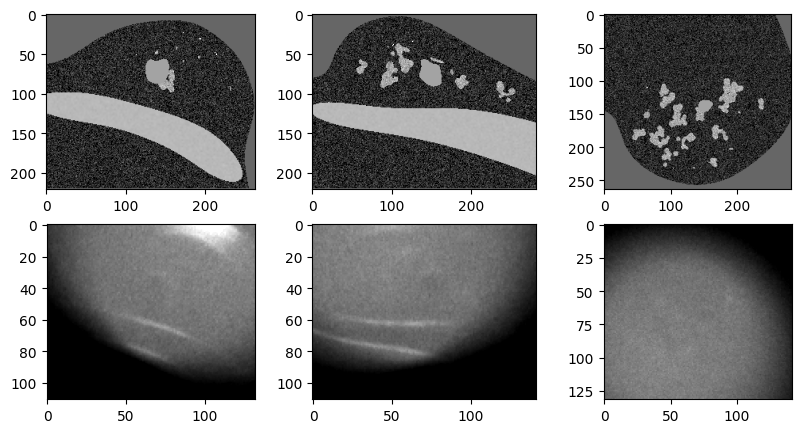

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
index = 0.5
ax[0,0].imshow(test[:, :, int(test.shape[2]*index)], cmap='gray', vmin=1400, vmax=1650)
ax[1,0].imshow(image1[:,:,int(image1.shape[2]*index)], cmap='gray', vmin=10000, vmax=50000)
index = 0.5
ax[0,1].imshow(test[:, int(test.shape[1]*index), :], cmap='gray', vmin=1400, vmax=1650)
ax[1,1].imshow(image1[:, int(image1.shape[1]*index), :], cmap='gray', vmin=10000, vmax=50000)
index = 0.4
ax[0,2].imshow(test[int(test.shape[0]*index), :, :], cmap='gray', vmin=1400, vmax=1650)
ax[1,2].imshow(image1[int(image1.shape[0]*index), :, :], cmap='gray', vmin=10000, vmax=50000)

In [51]:
image1

array([[[12492.894  , 12008.739  , 12480.682  , ...,  3064.3218 ,
          2634.8374 ,  2307.3508 ],
        [13148.772  , 13542.377  , 13352.036  , ...,  3298.7927 ,
          2695.9114 ,  2710.2703 ],
        [13723.358  , 13881.195  , 13314.155  , ...,  3619.717  ,
          2976.3232 ,  2994.8403 ],
        ...,
        [28687.236  , 28332.646  , 28084.76   , ..., 18015.379  ,
         18676.594  , 18659.008  ],
        [27454.162  , 27154.45   , 28377.262  , ..., 19012.217  ,
         18168.23   , 18321.863  ],
        [27402.098  , 26751.617  , 27458.707  , ..., 17497.701  ,
         17936.107  , 17737.688  ]],

       [[12068.266  , 13094.894  , 12194.397  , ...,  3117.986  ,
          2693.3728 ,  2282.3357 ],
        [12954.167  , 13869.813  , 12759.433  , ...,  3297.8145 ,
          2837.9006 ,  2709.233  ],
        [13842.224  , 13594.691  , 14044.704  , ...,  3474.0542 ,
          3046.6174 ,  2949.5483 ],
        ...,
        [28244.732  , 28048.227  , 28846.596  , ..., 1